In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-data/thyroid0387.data


In [2]:
#requires libraries

from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [3]:
name= ['age','sex','on thyroxine','query on thyroxine' ,'on antithyroid medication','sick','pregnant','thyroid surgery','I131 treatment','query hypothyroid','query hyperthyroid','lithium','goitre',
'tumor','hypopituitary','psych','TSH measured','TSH','T3 measured','T3','TT4 measured','TT4','T4U measured','T4U','FTI measured','FTI','TBG measured','TBG','referral source','target']
data = pd.read_csv('../input/train-data/thyroid0387.data',sep=',',names = name)

In [4]:
data.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,target
0,29,F,f,f,f,f,f,f,f,t,...,f,?,f,?,f,?,f,?,other,-[840801013]
1,29,F,f,f,f,f,f,f,f,f,...,t,128,f,?,f,?,f,?,other,-[840801014]
2,41,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,11,other,-[840801042]
3,36,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,26,other,-[840803046]
4,32,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,36,other,S[840803047]


## Data Preprocessing

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        9172 non-null   int64 
 1   sex                        9172 non-null   object
 2   on thyroxine               9172 non-null   object
 3   query on thyroxine         9172 non-null   object
 4   on antithyroid medication  9172 non-null   object
 5   sick                       9172 non-null   object
 6   pregnant                   9172 non-null   object
 7   thyroid surgery            9172 non-null   object
 8   I131 treatment             9172 non-null   object
 9   query hypothyroid          9172 non-null   object
 10  query hyperthyroid         9172 non-null   object
 11  lithium                    9172 non-null   object
 12  goitre                     9172 non-null   object
 13  tumor                      9172 non-null   object
 14  hypopitu

In [6]:
data['target'] = data['target'].apply(lambda x:x.split('[')[0])
data['age'] = data['age'].apply(lambda x:x if  x >1 and x <100 else '?' )
data = data.drop('referral source',axis = 1)

In [7]:
#replace the all ? into NAN 
for  i in data.columns:
    data[i]  = data[i].replace('?',np.NaN)


In [8]:
# cat_col= data.select_dtypes('object')

# fig ,axes = plt.subplots(len(cat_col.columns),1, figsize=(10,100))
# j = 0
# for i in range(len(cat_col.columns)):
#     plt.sca(axes[i])
#     sb.countplot(x= cat_col[cat_col.columns[i]])
#     plt.xticks(rotation = 45)
#     ticks = range(0, 50, 5)
#     labels = ticks
#     plt.xticks(ticks, labels)


## Encoding the categorical values with mapping

In [9]:
sex = {'M':0,'F':1}
ont = {'f':0,'t':1}
data['sex'] = data['sex'].map(sex)
data['on thyroxine'] = data['on thyroxine'].map(ont)
data['query on thyroxine'] = data['query on thyroxine'].map(ont)
data['on antithyroid medication'] = data['on antithyroid medication'].map(ont)
data['sick'] = data['sick'].map(ont)
data['pregnant'] = data['pregnant'].map(ont)
data['thyroid surgery'] = data['thyroid surgery'].map(ont)
data['I131 treatment'] = data['I131 treatment'].map(ont)
data['query hypothyroid'] = data['query hypothyroid'].map(ont)
data['query hyperthyroid'] = data['query hyperthyroid'].map(ont)
data['lithium'] = data['lithium'].map(ont)
data['goitre'] = data['goitre'].map(ont)
data['tumor'] = data['tumor'].map(ont)
data['hypopituitary'] = data['hypopituitary'].map(ont)
data['psych'] = data['psych'].map(ont)
data['TSH measured'] = data['TSH measured'].map(ont)
data['T3 measured'] = data['T3 measured'].map(ont)
data['TT4 measured'] = data['TT4 measured'].map(ont)
data['T4U measured'] = data['T4U measured'].map(ont)
data['FTI measured'] = data['FTI measured'].map(ont)
data['TBG measured'] = data['TBG measured'].map(ont)

In [10]:
data.describe()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH measured,T3 measured,TT4 measured,T4U measured,FTI measured,TBG measured
count,9155.000000,8865.000000,9172.000000,9172.000000,9172.000000,9172.000000,9172.000000,9172.000000,9172.000000,9172.000000,...,9172.000000,9172.000000,9172.000000,9172.000000,9172.000000,9172.000000,9172.000000,9172.000000,9172.000000,9172.000000
mean,52.172256,0.685054,0.135194,0.016681,0.012647,0.037505,0.011666,0.014610,0.018426,0.068687,...,0.009158,0.026276,0.000218,0.045573,0.908199,0.716092,0.951810,0.911797,0.912560,0.038051
std,18.825346,0.464521,0.341949,0.128081,0.111752,0.190007,0.107383,0.119991,0.134492,0.252935,...,0.095265,0.159963,0.014766,0.208570,0.288761,0.450917,0.214179,0.283606,0.282494,0.191329
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,55.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,68.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,97.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
target = data[['target']]
data = data.drop(['target'],axis = 1)

In [12]:
data = data.drop(['TBG'],axis = 1)# as it contain high value on null values and remaing will be filled with median

In [13]:
data = data.fillna(data.median())

## Feature selection 

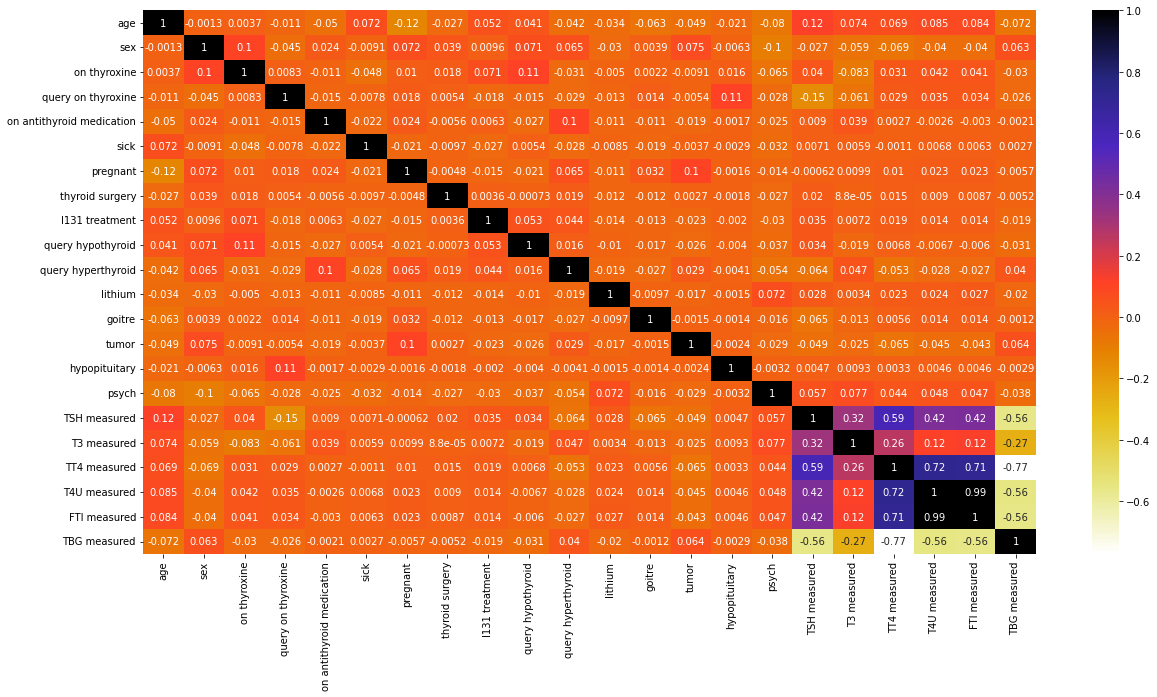

In [14]:
#using correlation method
plt.figure(figsize=(20,10))
cor = data.corr()
sb.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [15]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(data, 0.7)#based on heatmap observation thershod is 0.7
corr_features

{'FTI measured', 'T4U measured', 'TBG measured'}

In [16]:
data = data.drop(['FTI measured', 'T4U measured', 'TBG measured'],axis =1)

## Model training

In [17]:
x_train,x_test,y_train,y_test = train_test_split(data,target,test_size = 0.3,random_state = 42)

In [18]:
x_test = x_test.reset_index(drop = True)

#### Class balance using SMOTE oversmapling technique

We can observe imbalance in class we balance before model training,to avoid model bias

In [19]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy="not majority") # String
X_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)
y_train_ros = pd.DataFrame(y_train_ros)
y_train_ros.value_counts()

target
-         4760
A         4760
R         4760
Q         4760
P         4760
OI        4760
O         4760
N         4760
MK        4760
MI        4760
M         4760
LJ        4760
L         4760
KJ        4760
K         4760
J         4760
I         4760
H|K       4760
GKJ       4760
GK        4760
GI        4760
G         4760
FK        4760
F         4760
E         4760
D|R       4760
D         4760
C|I       4760
C         4760
B         4760
AK        4760
S         4760
dtype: int64

In [20]:
models = {
          "KNeighborsClassifier": KNeighborsClassifier(),
          "RandomForestClassifier": RandomForestClassifier(),
          "DecisionTree": DecisionTreeClassifier(random_state=0)}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(99)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    
    return model_scores

model_scores = fit_and_score(models, x_train, x_test, y_train, y_test)

model_scores

/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


{'KNeighborsClassifier': 0.7790697674418605,
 'RandomForestClassifier': 0.9186046511627907,
 'DecisionTree': 0.9131540697674418}

From above model scores we can observe that randomforestclassifier give good performace for dataset lets further working model tuning and bias reduction

RandomForestClassifier(n_estimators=100, *, criterion="gini", max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="auto", max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
A random forest classifier.

In [21]:
# from sklearn.preprocessing import StandardScaler
# scale = StandardScaler().fit(X_train_ros)
# x_train_scale = scale.transform(X_train_ros)
# x_test_scale = scale.transform(x_test)


In [22]:
clf = RandomForestClassifier(n_estimators =  250,max_features = 'auto',max_depth= 70,bootstrap = True,n_jobs = -1)
clf.fit(X_train_ros,y_train_ros)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(max_depth=70, n_estimators=250, n_jobs=-1)

In [23]:
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           -       0.95      0.95      0.95      2011
           A       0.78      0.78      0.78        36
          AK       0.70      0.64      0.67        11
           B       0.00      0.00      0.00         6
           C       0.00      0.00      0.00         2
         C|I       0.00      0.00      0.00         1
           D       1.00      1.00      1.00         2
           F       0.90      0.93      0.92        70
          FK       0.00      0.00      0.00         1
           G       0.94      0.97      0.95       105
          GI       0.50      0.50      0.50         2
          GK       0.91      0.91      0.91        11
         H|K       1.00      1.00      1.00         1
           I       0.82      0.77      0.79       116
           J       0.88      0.50      0.64        14
           K       0.85      0.94      0.89       148
          KJ       1.00      0.33      0.50         3
           L       0.65    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In classification report we can observe is for some class like B,GI the f1 score is 0 so our model is not generalized with dataset further we train our model with oversampled data to make our model more generalized over dataset

## Feature importance

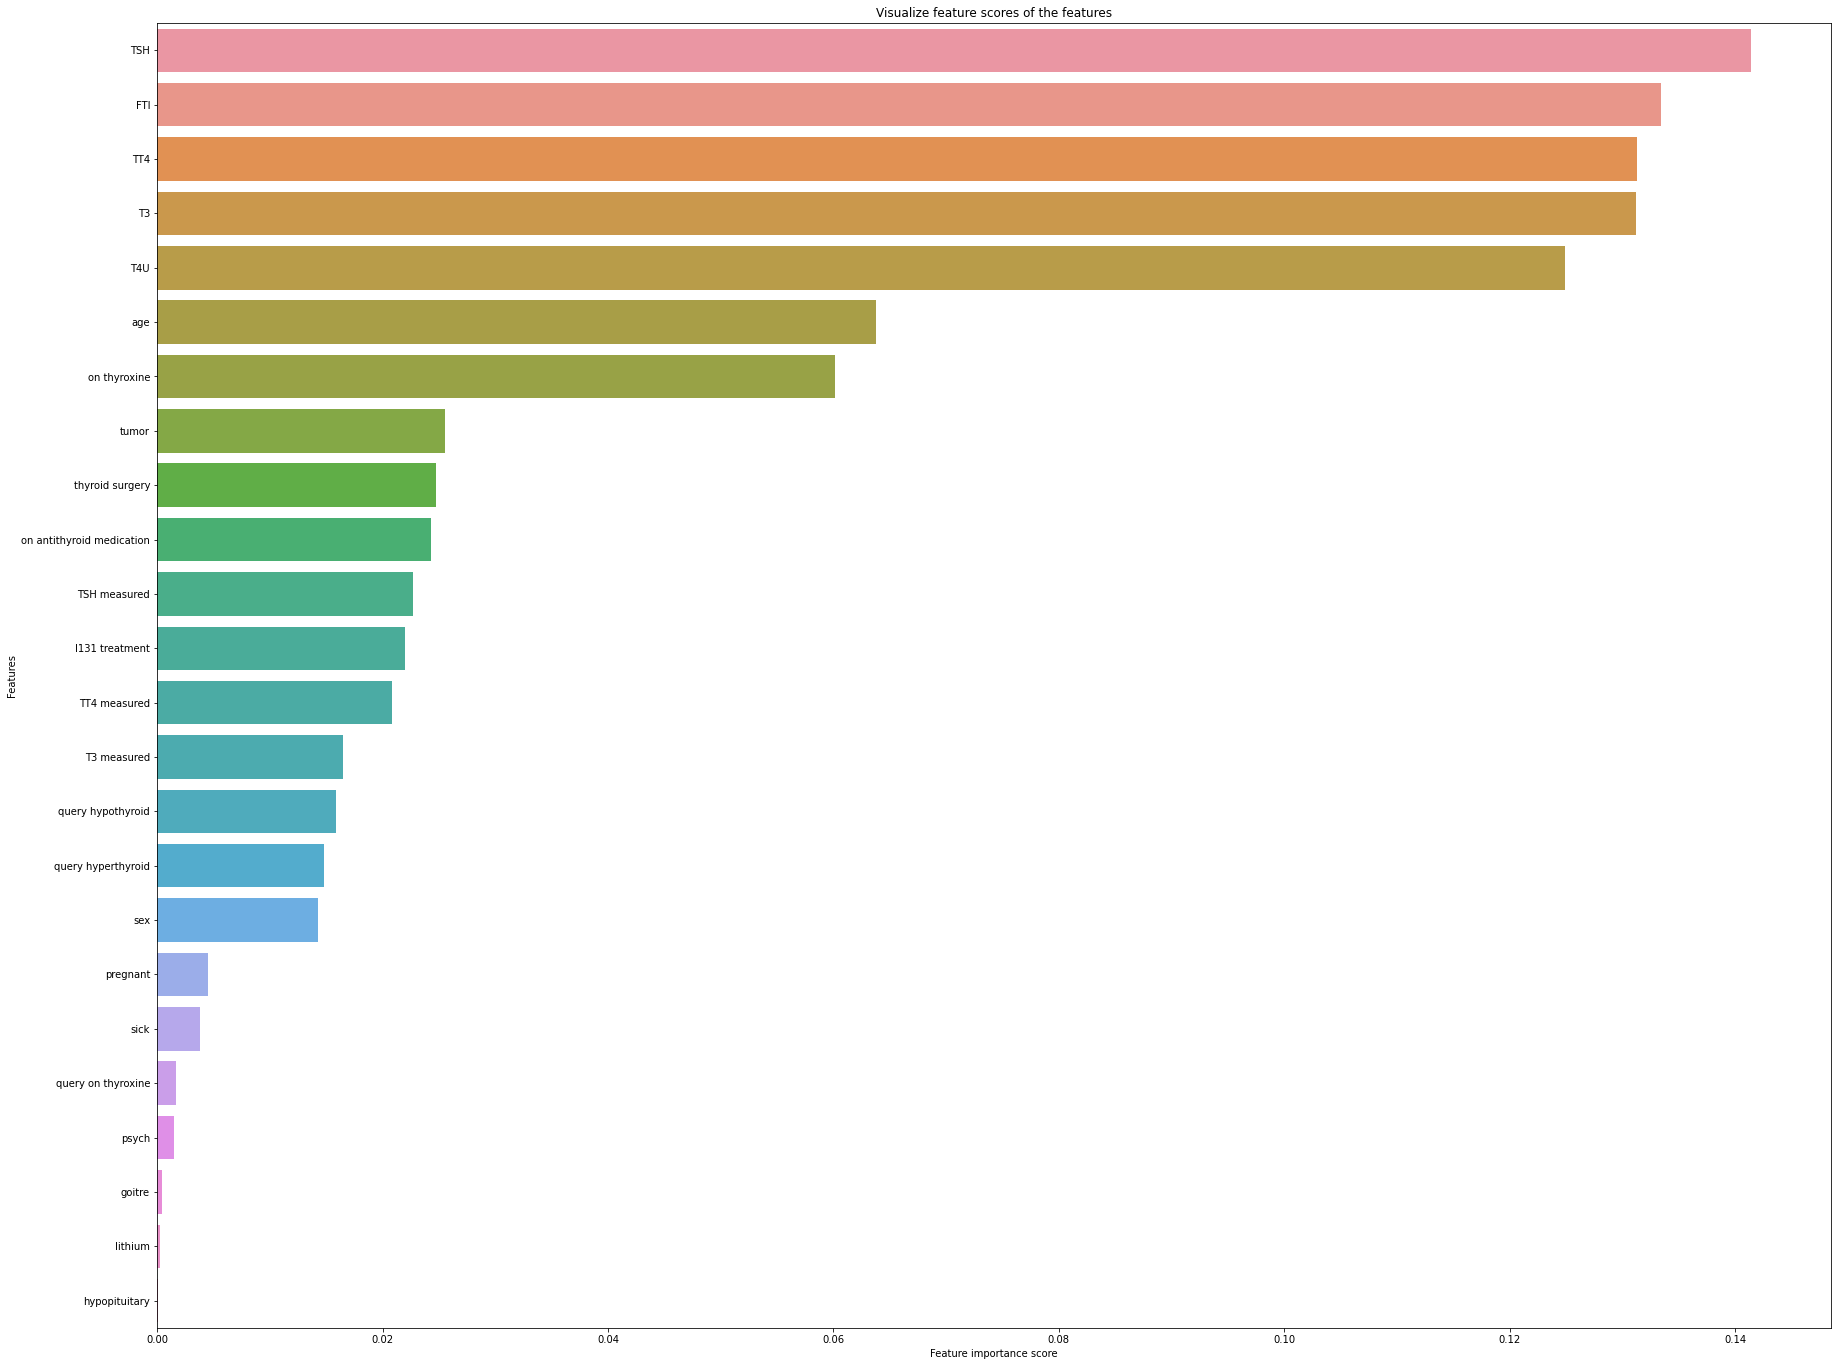

In [24]:
feature_scores = pd.Series(clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(30, 24))
ax = sb.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

## testing

In [25]:
def testing(val):
    test = val.to_numpy().reshape(1,-1)
    predicts = clf.predict(test)
    if predicts == ['-']:
        print(predicts)
        print("No dignosis required")
        
    if predicts == ['A'] or  predicts == ['B'] or  predicts == ['C']  or  predicts == ['D']:
        print(predicts)
        print("hyperthyroid  condition")
              
    if predicts == ['E'] or  predicts == ['F'] or  predicts == ['G'] or  predicts == ['H']:
        print(predicts)
        print("hypothyroid conditions")
              
              
    if predicts == ['I'] or  predicts == ['J']:
        print(predicts)
        print("binding protein")
              
    if predicts == ['K']:
        print(predicts)
        print("general health")
              
    if predicts == ['L'] or  predicts == ['M'] or  predicts == ['N']:
        print(predicts)
        print("replacement therapy")
              
    if predicts == ['O'] or  predicts == ['P'] or  predicts == ['Q']:
        print(predicts)
        print("antithyroid treatment")
              
    if predicts == ['R'] or  predicts == ['S'] or  predicts == ['T']:
        print(predicts)
        print("miscellaneous condition")
        
val = x_test.loc[28]
testing(val)

['K']
general health


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [26]:
c = """
hyperthyroid conditions:

		A	hyperthyroid
		B	T3 toxic
		C	toxic goitre
		D	secondary toxic

	hypothyroid conditions:

		E	hypothyroid
		F	primary hypothyroid
		G	compensated hypothyroid
		H	secondary hypothyroid

	binding protein:

		I	increased binding protein
		J	decreased binding protein

	general health:

		K	concurrent non-thyroidal illness

	replacement therapy:

		L	consistent with replacement therapy
		M	underreplaced
		N	overreplaced

	antithyroid treatment:

		O	antithyroid drugs
		P	I131 treatment
		Q	surgery

	miscellaneous:

		R	discordant assay results
		S	elevated TBG
		T	elevated thyroid hormones

"""
print(c)


hyperthyroid conditions:

		A	hyperthyroid
		B	T3 toxic
		C	toxic goitre
		D	secondary toxic

	hypothyroid conditions:

		E	hypothyroid
		F	primary hypothyroid
		G	compensated hypothyroid
		H	secondary hypothyroid

	binding protein:

		I	increased binding protein
		J	decreased binding protein

	general health:

		K	concurrent non-thyroidal illness

	replacement therapy:

		L	consistent with replacement therapy
		M	underreplaced
		N	overreplaced

	antithyroid treatment:

		O	antithyroid drugs
		P	I131 treatment
		Q	surgery

	miscellaneous:

		R	discordant assay results
		S	elevated TBG
		T	elevated thyroid hormones


